Part 3 concerns non symmetric distributions, such as chi-squared distributed errors. They are of interest because they are non-symmetric and positive.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html

https://en.wikipedia.org/wiki/Skew_normal_distribution

Also, the previous functions are refactored. A more general function is used here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
iterations = 10000
n = 30
secret_beta = 2

It is good to refactor everything into functions! Avoid repeated code!

In [3]:
var_u_list = [0, 1.5, 2, 2.5,3.0,4.5,6.0,8.0,10.0]
var_eps_list = [1.5, 2, 2.5]

def experiment(distribution_label, gen_err_u, gen_err_eps):
    print(f"{distribution_label} distributed epsilon")
    
    beta_dict = {}
    sigma_dict = {}

    for var_u in var_u_list:
        for var_eps in var_eps_list:
            bias_beta = np.array([])
            sqerr_beta = np.array([])
            bias_beta_adj = np.array([])
            sqerr_beta_adj = np.array([])

            bias_sigma = np.array([])
            sqerr_sigma = np.array([])
            bias_sigma_adj_v2 = np.array([])
            sqerr_sigma_adj_v2 = np.array([])

            for _ in range(iterations):
                x = np.linspace(-20,20,n)
                if var_u > 0:
                    x_obs = x + gen_err_u(var_u, n)
                else:
                    x_obs = x
                y = x*secret_beta + gen_err_x(var_eps, n)

                beta_est = np.cov(x_obs, y, ddof=0)[0][1]/np.var(x_obs, ddof=0)
                beta_est_adj = np.cov(x_obs, y, ddof=1)[0][1]/(np.var(x_obs, ddof=1) - var_u)
                
                vx = np.var(x_obs, ddof=0) - var_u
                vu = var_u
                l = vx/(vx+vu);

                sigma_est = np.sum((y - beta_est * x_obs) ** 2) / (n-1)
#                 sigma_est_adj_v2 = np.var(y, ddof=0) - (beta_est_adj ** 2) *  vx
                sigma_est_adj_v2 = np.sum((y - beta_est * x_obs) ** 2) / (n-1) - (1-l)**2*beta_est_adj**2*vx - l**2*beta_est_adj**2*vu
                
#                 print(sigma_est_adj_v2, np.sum((y - beta_est_adj * x_obs) ** 2) / (n-1) - beta_est_adj ** 2 * vu)

                bias_beta = np.append(bias_beta, (beta_est-secret_beta))
                sqerr_beta = np.append(sqerr_beta, (beta_est-secret_beta)**2)
                bias_beta_adj = np.append(bias_beta_adj, (beta_est_adj-secret_beta))
                sqerr_beta_adj = np.append(sqerr_beta_adj, (beta_est_adj-secret_beta)**2)

                bias_sigma = np.append(bias_sigma, sigma_est-var_eps)
                sqerr_sigma = np.append(sqerr_sigma, (sigma_est-var_eps)**2)
                bias_sigma_adj_v2 = np.append(bias_sigma_adj_v2, sigma_est_adj_v2-var_eps)
                sqerr_sigma_adj_v2 = np.append(sqerr_sigma_adj_v2, (sigma_est_adj_v2-var_eps)**2)

            print("var_u=%.2f, var_eps=%.2f:  OLS: MBE = %f, MSE = %f; Sigma MBE = %f, MSE = %f"%(var_u, var_eps, bias_beta.mean(), sqerr_beta.mean(), bias_sigma.mean(), sqerr_sigma.mean()))

            print("var_u=%.2f, var_eps=%.2f:  MME: MBE = %f, MSE = %f; Sigma MBE = %f, MSE = %f"%(var_u, var_eps, bias_beta_adj.mean(), sqerr_beta_adj.mean(), bias_sigma_adj_v2.mean(), sqerr_sigma_adj_v2.mean()))
        
            beta_dict[(var_u, var_eps)] = {}
            beta_dict[(var_u, var_eps)]['bias_ols'] = bias_beta.mean()
            beta_dict[(var_u, var_eps)]['sqerr_ols'] = sqerr_beta.mean()
            beta_dict[(var_u, var_eps)]['bias_ols_corr'] = bias_beta_adj.mean()
            beta_dict[(var_u, var_eps)]['sqerr_ols_corr'] = sqerr_beta_adj.mean()
            
            sigma_dict[(var_u, var_eps)] = {}
            sigma_dict[(var_u, var_eps)]['bias_ols'] = bias_sigma.mean()
            sigma_dict[(var_u, var_eps)]['sqerr_ols'] = sqerr_sigma.mean()
            sigma_dict[(var_u, var_eps)]['bias_ols_corr_v2'] = bias_sigma_adj_v2.mean()
            sigma_dict[(var_u, var_eps)]['sqerr_ols_corr_v2'] = sqerr_sigma_adj_v2.mean()
            
        
    return beta_dict, sigma_dict

In [4]:
def show_plot(title, dicts, x_label, key1, key2, y_min, y_max):
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(len(var_u_list), len(var_eps_list), figsize=(15,30))

    for i in range(len(var_u_list)):
        for j in range(len(var_eps_list)):
            labels = x_label
            vals1 = [ d[(var_u_list[i], var_eps_list[j])][key1] for d in dicts]
            vals2 = [ d[(var_u_list[i], var_eps_list[j])][key2] for d in dicts]
            
            x = np.arange(len(labels))  # the label locations
            width = 0.35  # the width of the bars
            
            axs[i,j].set_title(title + ': $\\sigma^2_u=%.2f$, $\\sigma^2_\\epsilon=%.2f$'%(var_u_list[i], var_eps_list[j]))
            axs[i,j].bar(x - width/2, vals1, width, label="OLS")
            axs[i,j].bar(x + width/2, vals2, width, label="MME")
            axs[i,j].set_xticks(x)
            axs[i,j].set_xticklabels(labels)
            axs[i,j].legend()
            
            # axs[i,j].bar(x_label,vals,color=['tab:blue', 'tab:orange', 'tab:green'][:len(dicts)])
            axs[i][j].set_ylim(y_min, y_max)
            
    plt.subplots_adjust(hspace=0.3)

    plt.show()

Generate tables

In [5]:
def gen_table(d, field_1, field_2):
    for var_u in var_u_list:
        if var_u == 0:
            continue
        print("$\sigma^2_u = %.1f$"%var_u, end="")
        for var_eps in var_eps_list:
            print("&%.6f"%d[(var_u, var_eps)][field_1], end="")
            print("&%.6f"%d[(var_u, var_eps)][field_2], end="")
            
        print(r"\\")

In [6]:
def gen_table2(d1, d2, field_1, field_2):
    for var_u in var_u_list:
        if var_u == 0:
            continue
        print("$\sigma^2_u = %.1f$"%var_u, end="")
        for var_eps in var_eps_list:
            print("&%.6f"%(d2[(var_u, var_eps)][field_1]-d1[(var_u, var_eps)][field_1]), end="")
            print("&%.6f"%(d2[(var_u, var_eps)][field_2]-d1[(var_u, var_eps)][field_2]), end="")
            
        print(r"\\")

Perform experiments

In [7]:
def gen_err_x(var, n):
    return np.random.normal(scale=np.sqrt(var), size=n)

def gen_err_eps(var, n):
    return np.random.normal(scale=np.sqrt(var), size=n)

beta_dict_normal, sigma_dict_normal = experiment("Normal", gen_err_x, gen_err_eps)

Normal distributed epsilon
var_u=0.00, var_eps=1.50:  OLS: MBE = -0.000188, MSE = 0.000346; Sigma MBE = 0.002638, MSE = 0.150847
var_u=0.00, var_eps=1.50:  MME: MBE = -0.000188, MSE = 0.000346; Sigma MBE = 0.002638, MSE = 0.150847
var_u=0.00, var_eps=2.00:  OLS: MBE = -0.000114, MSE = 0.000477; Sigma MBE = 0.005647, MSE = 0.276744
var_u=0.00, var_eps=2.00:  MME: MBE = -0.000114, MSE = 0.000477; Sigma MBE = 0.005647, MSE = 0.276744
var_u=0.00, var_eps=2.50:  OLS: MBE = -0.000217, MSE = 0.000583; Sigma MBE = -0.014956, MSE = 0.424303
var_u=0.00, var_eps=2.50:  MME: MBE = -0.000217, MSE = 0.000583; Sigma MBE = -0.014956, MSE = 0.424303
var_u=1.50, var_eps=1.50:  OLS: MBE = -0.018406, MSE = 0.002026; Sigma MBE = 5.900404, MSE = 38.530776
var_u=1.50, var_eps=1.50:  MME: MBE = 0.001800, MSE = 0.001781; Sigma MBE = -0.050233, MSE = 3.780289
var_u=1.50, var_eps=2.00:  OLS: MBE = -0.019667, MSE = 0.002168; Sigma MBE = 5.955353, MSE = 39.882151
var_u=1.50, var_eps=2.00:  MME: MBE = 0.000505, MSE

In [8]:
gen_table(beta_dict_normal, 'bias_ols', 'bias_ols_corr')

$\sigma^2_u = 1.5$&-0.018406&0.001800&-0.019667&0.000505&-0.019292&0.000895\\
$\sigma^2_u = 2.0$&-0.025018&0.001851&-0.024511&0.002371&-0.025436&0.001416\\
$\sigma^2_u = 2.5$&-0.031520&0.001958&-0.029421&0.004139&-0.031215&0.002285\\
$\sigma^2_u = 3.0$&-0.036707&0.003436&-0.036961&0.003156&-0.037188&0.002923\\
$\sigma^2_u = 4.5$&-0.054875&0.004901&-0.056101&0.003559&-0.055655&0.004057\\
$\sigma^2_u = 6.0$&-0.073502&0.005575&-0.074400&0.004531&-0.072289&0.006886\\
$\sigma^2_u = 8.0$&-0.097213&0.007125&-0.097049&0.007313&-0.096943&0.007427\\
$\sigma^2_u = 10.0$&-0.120748&0.008388&-0.119521&0.009902&-0.119075&0.010326\\


In [9]:
gen_table(beta_dict_normal, 'sqerr_ols', 'sqerr_ols_corr')

$\sigma^2_u = 1.5$&0.002026&0.001781&0.002168&0.001873&0.002304&0.002029\\
$\sigma^2_u = 2.0$&0.002732&0.002267&0.002830&0.002396&0.002987&0.002506\\
$\sigma^2_u = 2.5$&0.003544&0.002801&0.003559&0.002964&0.003688&0.002967\\
$\sigma^2_u = 3.0$&0.004319&0.003334&0.004455&0.003456&0.004653&0.003648\\
$\sigma^2_u = 4.5$&0.007088&0.004862&0.007457&0.005112&0.007360&0.005045\\
$\sigma^2_u = 6.0$&0.010532&0.006487&0.010886&0.006739&0.010648&0.006833\\
$\sigma^2_u = 8.0$&0.016103&0.009102&0.016091&0.009100&0.016123&0.009138\\
$\sigma^2_u = 10.0$&0.022169&0.011236&0.022276&0.011799&0.022216&0.011831\\


In [10]:
gen_table(sigma_dict_normal, 'bias_ols', 'bias_ols_corr_v2')

$\sigma^2_u = 1.5$&5.900404&-0.050233&5.955353&0.012206&5.947017&0.001355\\
$\sigma^2_u = 2.0$&7.888963&-0.018928&7.901321&-0.010901&7.879309&-0.025664\\
$\sigma^2_u = 2.5$&9.784296&-0.068626&9.802717&-0.071802&9.869316&0.012851\\
$\sigma^2_u = 3.0$&11.798199&-0.002881&11.757166&-0.041108&11.793174&-0.002928\\
$\sigma^2_u = 4.5$&17.597952&0.047601&17.466602&-0.062097&17.455414&-0.081391\\
$\sigma^2_u = 6.0$&23.120196&-0.063780&23.033594&-0.129041&23.132393&-0.083139\\
$\sigma^2_u = 8.0$&30.406714&-0.150267&30.219614&-0.342906&30.389711&-0.176612\\
$\sigma^2_u = 10.0$&37.647515&-0.097025&37.724051&-0.077960&37.508399&-0.310914\\


In [11]:
gen_table(sigma_dict_normal, 'sqerr_ols', 'sqerr_ols_corr_v2')

$\sigma^2_u = 1.5$&38.530776&3.780289&39.882151&4.471836&40.209234&4.935117\\
$\sigma^2_u = 2.0$&68.339624&6.241460&69.219747&6.910293&69.534180&7.638777\\
$\sigma^2_u = 2.5$&104.624534&9.105856&105.756458&9.905827&108.054738&10.961756\\
$\sigma^2_u = 3.0$&151.461698&12.734043&151.520531&13.621373&153.743436&15.163531\\
$\sigma^2_u = 4.5$&335.041092&26.578374&331.019140&27.398219&331.821175&28.443274\\
$\sigma^2_u = 6.0$&576.830404&45.826542&575.198317&47.750947&581.386469&49.216860\\
$\sigma^2_u = 8.0$&995.830908&79.148108&984.510480&79.308313&998.785315&83.400332\\
$\sigma^2_u = 10.0$&1520.990888&117.975374&1528.874963&120.145671&1516.974233&125.296896\\


In [12]:
def gen_err_x(var, n):
    return np.random.standard_t(df=2*var/(var-1), size=n) # var=df/(df-2)

def gen_err_eps(var, n):
    return np.random.standard_t(df=2*var/(var-1), size=n)

beta_dict_t, sigma_dict_t = experiment("Student-T", gen_err_x, gen_err_eps)

Student-T distributed epsilon
var_u=0.00, var_eps=1.50:  OLS: MBE = -0.000124, MSE = 0.000355; Sigma MBE = -0.005014, MSE = 0.344340
var_u=0.00, var_eps=1.50:  MME: MBE = -0.000124, MSE = 0.000355; Sigma MBE = -0.005014, MSE = 0.344340
var_u=0.00, var_eps=2.00:  OLS: MBE = 0.000175, MSE = 0.000459; Sigma MBE = -0.022737, MSE = 1.504203
var_u=0.00, var_eps=2.00:  MME: MBE = 0.000175, MSE = 0.000459; Sigma MBE = -0.022737, MSE = 1.504203
var_u=0.00, var_eps=2.50:  OLS: MBE = -0.000189, MSE = 0.000589; Sigma MBE = -0.005425, MSE = 9.540943
var_u=0.00, var_eps=2.50:  MME: MBE = -0.000189, MSE = 0.000589; Sigma MBE = -0.005425, MSE = 9.540943
var_u=1.50, var_eps=1.50:  OLS: MBE = -0.018811, MSE = 0.002112; Sigma MBE = 5.965444, MSE = 42.851635
var_u=1.50, var_eps=1.50:  MME: MBE = 0.001391, MSE = 0.001854; Sigma MBE = 0.017129, MSE = 7.429251
var_u=1.50, var_eps=2.00:  OLS: MBE = -0.019199, MSE = 0.002179; Sigma MBE = 5.949026, MSE = 44.646925
var_u=1.50, var_eps=2.00:  MME: MBE = 0.000988,

In [13]:
gen_table(beta_dict_t, 'bias_ols', 'bias_ols_corr')

$\sigma^2_u = 1.5$&-0.018811&0.001391&-0.019199&0.000988&-0.018163&0.002050\\
$\sigma^2_u = 2.0$&-0.024563&0.002314&-0.024635&0.002238&-0.024720&0.002157\\
$\sigma^2_u = 2.5$&-0.031062&0.002428&-0.031050&0.002448&-0.030458&0.003071\\
$\sigma^2_u = 3.0$&-0.034826&0.005397&-0.035187&0.005009&-0.035580&0.004603\\
$\sigma^2_u = 4.5$&-0.045805&0.014550&-0.048785&0.011340&-0.045181&0.015206\\
$\sigma^2_u = 6.0$&-0.054096&0.026632&-0.054759&0.025926&-0.054605&0.026035\\
$\sigma^2_u = 8.0$&-0.061836&0.046525&-0.060023&0.048540&-0.061507&0.046848\\
$\sigma^2_u = 10.0$&-0.066070&0.070679&-0.067018&0.069615&-0.065713&0.071101\\


In [14]:
gen_table(beta_dict_t, 'sqerr_ols', 'sqerr_ols_corr')

$\sigma^2_u = 1.5$&0.002112&0.001854&0.002179&0.001905&0.002279&0.002051\\
$\sigma^2_u = 2.0$&0.002912&0.002481&0.003040&0.002609&0.003132&0.002699\\
$\sigma^2_u = 2.5$&0.004094&0.003409&0.004211&0.003528&0.004270&0.003635\\
$\sigma^2_u = 3.0$&0.005661&0.004913&0.005470&0.004671&0.005644&0.004827\\
$\sigma^2_u = 4.5$&0.009523&0.008639&0.010456&0.009277&0.009140&0.008293\\
$\sigma^2_u = 6.0$&0.014130&0.013794&0.013723&0.013223&0.013692&0.013231\\
$\sigma^2_u = 8.0$&0.017969&0.019371&0.016112&0.017761&0.017037&0.018482\\
$\sigma^2_u = 10.0$&0.019388&0.024422&0.020242&0.025071&0.018737&0.023675\\


In [15]:
gen_table2(beta_dict_normal, beta_dict_t, 'bias_ols', 'bias_ols_corr')

$\sigma^2_u = 1.5$&-0.000405&-0.000409&0.000469&0.000483&0.001129&0.001155\\
$\sigma^2_u = 2.0$&0.000455&0.000463&-0.000124&-0.000133&0.000717&0.000742\\
$\sigma^2_u = 2.5$&0.000458&0.000470&-0.001629&-0.001691&0.000757&0.000786\\
$\sigma^2_u = 3.0$&0.001881&0.001961&0.001774&0.001853&0.001608&0.001680\\
$\sigma^2_u = 4.5$&0.009069&0.009649&0.007316&0.007781&0.010474&0.011148\\
$\sigma^2_u = 6.0$&0.019406&0.021057&0.019641&0.021394&0.017684&0.019149\\
$\sigma^2_u = 8.0$&0.035377&0.039400&0.037027&0.041226&0.035436&0.039422\\
$\sigma^2_u = 10.0$&0.054678&0.062291&0.052503&0.059713&0.053362&0.060775\\


In [16]:
gen_table2(beta_dict_normal, beta_dict_t, 'sqerr_ols', 'sqerr_ols_corr')

$\sigma^2_u = 1.5$&0.000086&0.000073&0.000011&0.000031&-0.000024&0.000022\\
$\sigma^2_u = 2.0$&0.000181&0.000214&0.000210&0.000212&0.000145&0.000193\\
$\sigma^2_u = 2.5$&0.000550&0.000608&0.000652&0.000565&0.000582&0.000668\\
$\sigma^2_u = 3.0$&0.001342&0.001579&0.001015&0.001215&0.000990&0.001178\\
$\sigma^2_u = 4.5$&0.002435&0.003777&0.002999&0.004165&0.001780&0.003248\\
$\sigma^2_u = 6.0$&0.003597&0.007307&0.002836&0.006484&0.003044&0.006398\\
$\sigma^2_u = 8.0$&0.001866&0.010269&0.000021&0.008661&0.000914&0.009344\\
$\sigma^2_u = 10.0$&-0.002781&0.013186&-0.002034&0.013272&-0.003479&0.011843\\


In [17]:
gen_table(sigma_dict_t, 'bias_ols', 'bias_ols_corr_v2')

$\sigma^2_u = 1.5$&5.965444&0.017129&5.949026&0.002994&5.852522&-0.099986\\
$\sigma^2_u = 2.0$&7.873037&-0.038917&7.794577&-0.117039&7.837349&-0.073789\\
$\sigma^2_u = 2.5$&9.613666&-0.245337&9.697142&-0.162316&9.591657&-0.274076\\
$\sigma^2_u = 3.0$&11.240567&-0.587908&11.061106&-0.762236&11.091512&-0.727538\\
$\sigma^2_u = 4.5$&14.674276&-3.058067&15.130487&-2.549836&14.349906&-3.392302\\
$\sigma^2_u = 6.0$&17.308219&-6.392124&17.300402&-6.380649&17.289769&-6.394398\\
$\sigma^2_u = 8.0$&19.391143&-12.403962&18.999681&-12.842478&19.122997&-12.675239\\
$\sigma^2_u = 10.0$&20.359688&-19.757988&20.806443&-19.278803&20.337719&-19.788499\\


In [18]:
gen_table(sigma_dict_t, 'sqerr_ols', 'sqerr_ols_corr_v2')

$\sigma^2_u = 1.5$&42.851635&7.429251&44.646925&9.417269&47.303721&13.233213\\
$\sigma^2_u = 2.0$&90.739181&29.905215&88.083920&28.419856&96.305849&35.838509\\
$\sigma^2_u = 2.5$&167.755054&79.503490&181.578188&92.099801&182.441974&94.903265\\
$\sigma^2_u = 3.0$&284.186452&168.747879&278.572350&166.286730&276.831587&163.997266\\
$\sigma^2_u = 4.5$&621.524421&453.668034&712.260002&535.305676&588.075696&427.984632\\
$\sigma^2_u = 6.0$&1059.949532&894.596872&988.210829&815.597278&1118.336892&940.571666\\
$\sigma^2_u = 8.0$&1433.607905&1384.842799&1208.084274&1158.996324&1213.814914&1157.835613\\
$\sigma^2_u = 10.0$&1430.156559&1641.357813&1618.590469&1813.400195&1429.762567&1631.738065\\


In [19]:
gen_table2(sigma_dict_normal, sigma_dict_t, 'bias_ols', 'bias_ols_corr_v2')

$\sigma^2_u = 1.5$&0.065040&0.067362&-0.006327&-0.009212&-0.094495&-0.101341\\
$\sigma^2_u = 2.0$&-0.015926&-0.019989&-0.106743&-0.106139&-0.041960&-0.048125\\
$\sigma^2_u = 2.5$&-0.170630&-0.176711&-0.105574&-0.090515&-0.277659&-0.286927\\
$\sigma^2_u = 3.0$&-0.557633&-0.585027&-0.696060&-0.721128&-0.701662&-0.724610\\
$\sigma^2_u = 4.5$&-2.923676&-3.105667&-2.336115&-2.487739&-3.105508&-3.310911\\
$\sigma^2_u = 6.0$&-5.811977&-6.328344&-5.733192&-6.251608&-5.842623&-6.311259\\
$\sigma^2_u = 8.0$&-11.015571&-12.253694&-11.219933&-12.499572&-11.266714&-12.498626\\
$\sigma^2_u = 10.0$&-17.287827&-19.660963&-16.917608&-19.200842&-17.170679&-19.477585\\


In [20]:
gen_table2(sigma_dict_normal, sigma_dict_t, 'sqerr_ols', 'sqerr_ols_corr_v2')

$\sigma^2_u = 1.5$&4.320859&3.648962&4.764773&4.945432&7.094487&8.298096\\
$\sigma^2_u = 2.0$&22.399557&23.663755&18.864172&21.509563&26.771668&28.199732\\
$\sigma^2_u = 2.5$&63.130521&70.397634&75.821730&82.193974&74.387236&83.941509\\
$\sigma^2_u = 3.0$&132.724754&156.013836&127.051819&152.665357&123.088151&148.833734\\
$\sigma^2_u = 4.5$&286.483328&427.089660&381.240862&507.907457&256.254521&399.541359\\
$\sigma^2_u = 6.0$&483.119128&848.770330&413.012512&767.846331&536.950423&891.354806\\
$\sigma^2_u = 8.0$&437.776996&1305.694690&223.573794&1079.688011&215.029599&1074.435281\\
$\sigma^2_u = 10.0$&-90.834328&1523.382439&89.715506&1693.254524&-87.211667&1506.441169\\


In [21]:
def gen_err_x(var, n):
    return np.random.chisquare(df=var/2.0, size=n) - var/2.0# var=2*dof

def gen_err_eps(var, n):
    return np.random.chisquare(df=var/2.0, size=n) - var/2.0

beta_dict_chi, sigma_dict_chi = experiment("ChiSq", gen_err_x, gen_err_eps)

ChiSq distributed epsilon
var_u=0.00, var_eps=1.50:  OLS: MBE = 0.000201, MSE = 0.000358; Sigma MBE = 0.033716, MSE = 1.490189
var_u=0.00, var_eps=1.50:  MME: MBE = 0.000201, MSE = 0.000358; Sigma MBE = 0.033716, MSE = 1.490189
var_u=0.00, var_eps=2.00:  OLS: MBE = 0.000259, MSE = 0.000464; Sigma MBE = 0.018373, MSE = 1.936359
var_u=0.00, var_eps=2.00:  MME: MBE = 0.000259, MSE = 0.000464; Sigma MBE = 0.018373, MSE = 1.936359
var_u=0.00, var_eps=2.50:  OLS: MBE = 0.000073, MSE = 0.000588; Sigma MBE = 0.007073, MSE = 2.494662
var_u=0.00, var_eps=2.50:  MME: MBE = 0.000073, MSE = 0.000588; Sigma MBE = 0.007073, MSE = 2.494662
var_u=1.50, var_eps=1.50:  OLS: MBE = -0.018624, MSE = 0.002205; Sigma MBE = 5.893220, MSE = 57.156508
var_u=1.50, var_eps=1.50:  MME: MBE = 0.001580, MSE = 0.001958; Sigma MBE = -0.056369, MSE = 23.096732
var_u=1.50, var_eps=2.00:  OLS: MBE = -0.017994, MSE = 0.002274; Sigma MBE = 5.925753, MSE = 59.199434
var_u=1.50, var_eps=2.00:  MME: MBE = 0.002220, MSE = 0.002

In [22]:
gen_table(beta_dict_chi, 'bias_ols', 'bias_ols_corr')

$\sigma^2_u = 1.5$&-0.018624&0.001580&-0.017994&0.002220&-0.018908&0.001285\\
$\sigma^2_u = 2.0$&-0.024808&0.002076&-0.025817&0.001020&-0.024370&0.002517\\
$\sigma^2_u = 2.5$&-0.030362&0.003170&-0.031010&0.002494&-0.030079&0.003481\\
$\sigma^2_u = 3.0$&-0.036793&0.003351&-0.037685&0.002393&-0.037465&0.002621\\
$\sigma^2_u = 4.5$&-0.054270&0.005575&-0.055211&0.004503&-0.056487&0.003124\\
$\sigma^2_u = 6.0$&-0.072231&0.006964&-0.072339&0.006804&-0.072609&0.006531\\
$\sigma^2_u = 8.0$&-0.097065&0.007307&-0.097076&0.007311&-0.096631&0.007895\\
$\sigma^2_u = 10.0$&-0.118317&0.011277&-0.116507&0.013404&-0.118055&0.011505\\


In [23]:
gen_table(beta_dict_chi, 'sqerr_ols', 'sqerr_ols_corr')

$\sigma^2_u = 1.5$&0.002205&0.001958&0.002274&0.002053&0.002460&0.002206\\
$\sigma^2_u = 2.0$&0.002944&0.002501&0.003080&0.002584&0.003201&0.002792\\
$\sigma^2_u = 2.5$&0.003712&0.003059&0.003838&0.003142&0.003863&0.003232\\
$\sigma^2_u = 3.0$&0.004493&0.003508&0.004917&0.003890&0.004644&0.003598\\
$\sigma^2_u = 4.5$&0.007488&0.005382&0.007612&0.005388&0.007981&0.005624\\
$\sigma^2_u = 6.0$&0.010957&0.007206&0.011047&0.007281&0.011212&0.007411\\
$\sigma^2_u = 8.0$&0.016616&0.009711&0.016813&0.009960&0.016772&0.010004\\
$\sigma^2_u = 10.0$&0.022696&0.012718&0.022178&0.012613&0.022977&0.013127\\


In [24]:
gen_table2(beta_dict_normal, beta_dict_chi, 'bias_ols', 'bias_ols_corr')

$\sigma^2_u = 1.5$&-0.000219&-0.000220&0.001673&0.001715&0.000383&0.000390\\
$\sigma^2_u = 2.0$&0.000210&0.000225&-0.001305&-0.001351&0.001066&0.001102\\
$\sigma^2_u = 2.5$&0.001158&0.001212&-0.001589&-0.001645&0.001136&0.001196\\
$\sigma^2_u = 3.0$&-0.000085&-0.000085&-0.000725&-0.000763&-0.000277&-0.000301\\
$\sigma^2_u = 4.5$&0.000605&0.000674&0.000890&0.000945&-0.000832&-0.000934\\
$\sigma^2_u = 6.0$&0.001271&0.001389&0.002061&0.002273&-0.000320&-0.000354\\
$\sigma^2_u = 8.0$&0.000148&0.000181&-0.000027&-0.000002&0.000312&0.000469\\
$\sigma^2_u = 10.0$&0.002431&0.002889&0.003014&0.003502&0.001020&0.001180\\


In [25]:
gen_table2(beta_dict_normal, beta_dict_chi, 'sqerr_ols', 'sqerr_ols_corr')

$\sigma^2_u = 1.5$&0.000180&0.000177&0.000106&0.000180&0.000156&0.000176\\
$\sigma^2_u = 2.0$&0.000212&0.000234&0.000250&0.000188&0.000214&0.000286\\
$\sigma^2_u = 2.5$&0.000168&0.000259&0.000279&0.000178&0.000175&0.000265\\
$\sigma^2_u = 3.0$&0.000174&0.000174&0.000462&0.000434&-0.000009&-0.000050\\
$\sigma^2_u = 4.5$&0.000399&0.000521&0.000155&0.000276&0.000621&0.000580\\
$\sigma^2_u = 6.0$&0.000425&0.000719&0.000161&0.000542&0.000563&0.000578\\
$\sigma^2_u = 8.0$&0.000513&0.000608&0.000723&0.000861&0.000649&0.000866\\
$\sigma^2_u = 10.0$&0.000527&0.001482&-0.000098&0.000814&0.000761&0.001296\\


In [26]:
gen_table(sigma_dict_chi, 'bias_ols', 'bias_ols_corr_v2')

$\sigma^2_u = 1.5$&5.893220&-0.056369&5.925753&-0.027765&5.910017&-0.038214\\
$\sigma^2_u = 2.0$&7.941942&0.031871&7.883551&-0.018494&7.897804&-0.016332\\
$\sigma^2_u = 2.5$&9.786872&-0.078416&9.747000&-0.111938&9.862407&-0.006246\\
$\sigma^2_u = 3.0$&11.764364&-0.036215&11.771377&-0.019330&11.577529&-0.215025\\
$\sigma^2_u = 4.5$&17.515282&-0.048596&17.354157&-0.191983&17.339678&-0.183992\\
$\sigma^2_u = 6.0$&23.076080&-0.143101&23.001147&-0.215374&22.952380&-0.258514\\
$\sigma^2_u = 8.0$&30.188767&-0.377915&30.370164&-0.198146&30.555481&-0.029103\\
$\sigma^2_u = 10.0$&37.399951&-0.459851&37.362384&-0.572358&37.111804&-0.761288\\


In [27]:
gen_table(sigma_dict_chi, 'sqerr_ols', 'sqerr_ols_corr_v2')

$\sigma^2_u = 1.5$&57.156508&23.096732&59.199434&24.756849&59.595066&25.384590\\
$\sigma^2_u = 2.0$&94.420321&32.593721&94.155136&33.209791&96.123602&35.016405\\
$\sigma^2_u = 2.5$&135.176838&41.299873&134.988694&41.911471&142.479071&47.127930\\
$\sigma^2_u = 3.0$&187.194973&51.476957&187.669689&52.236293&182.631566&51.413928\\
$\sigma^2_u = 4.5$&385.846689&85.801536&378.435062&83.682260&379.322162&85.748375\\
$\sigma^2_u = 6.0$&638.422049&118.133857&636.923293&119.730214&636.076559&122.171158\\
$\sigma^2_u = 8.0$&1057.790558&169.895222&1077.712211&178.676540&1093.595726&183.465213\\
$\sigma^2_u = 10.0$&1597.776001&237.689528&1599.654260&240.683626&1580.838713&245.632506\\


In [28]:
gen_table2(sigma_dict_normal, sigma_dict_chi, 'bias_ols', 'bias_ols_corr_v2')

$\sigma^2_u = 1.5$&-0.007185&-0.006136&-0.029600&-0.039971&-0.037000&-0.039569\\
$\sigma^2_u = 2.0$&0.052979&0.050799&-0.017770&-0.007594&0.018494&0.009332\\
$\sigma^2_u = 2.5$&0.002576&-0.009790&-0.055717&-0.040136&-0.006909&-0.019097\\
$\sigma^2_u = 3.0$&-0.033836&-0.033334&0.014211&0.021778&-0.215645&-0.212096\\
$\sigma^2_u = 4.5$&-0.082670&-0.096197&-0.112445&-0.129886&-0.115736&-0.102601\\
$\sigma^2_u = 6.0$&-0.044116&-0.079320&-0.032447&-0.086333&-0.180013&-0.175376\\
$\sigma^2_u = 8.0$&-0.217947&-0.227648&0.150550&0.144760&0.165770&0.147509\\
$\sigma^2_u = 10.0$&-0.247564&-0.362826&-0.361667&-0.494397&-0.396595&-0.450374\\


In [29]:
gen_table2(sigma_dict_normal, sigma_dict_chi, 'sqerr_ols', 'sqerr_ols_corr_v2')

$\sigma^2_u = 1.5$&18.625732&19.316444&19.317283&20.285012&19.385832&20.449473\\
$\sigma^2_u = 2.0$&26.080697&26.352261&24.935389&26.299499&26.589421&27.377628\\
$\sigma^2_u = 2.5$&30.552304&32.194016&29.232236&32.005644&34.424333&36.166174\\
$\sigma^2_u = 3.0$&35.733276&38.742914&36.149158&38.614920&28.888130&36.250397\\
$\sigma^2_u = 4.5$&50.805596&59.223162&47.415921&56.284041&47.500987&57.305102\\
$\sigma^2_u = 6.0$&61.591645&72.307314&61.724976&71.979267&54.690090&72.954298\\
$\sigma^2_u = 8.0$&61.959650&90.747114&93.201731&99.368226&94.810411&100.064881\\
$\sigma^2_u = 10.0$&76.785113&119.714154&70.779297&120.537955&63.864480&120.335609\\


$\sigma^2_u = 0$ tables

In [39]:
def gen_table0(d1, d2, d3, field):
    for var_eps in var_eps_list:
        print("$\sigma^2_\epsilon = %.1f$"%var_eps, end="")
        print("&%.6f&%.6f&%.6f"%(d1[(0, var_eps)][field], d2[(0, var_eps)][field], d3[(0, var_eps)][field]), end="")
        print(r"\\")

In [40]:
gen_table0(beta_dict_normal, beta_dict_t, beta_dict_chi, "bias_ols")

$\sigma^2_\epsilon = 1.5$&-0.000188&-0.000124&0.000201\\
$\sigma^2_\epsilon = 2.0$&-0.000114&0.000175&0.000259\\
$\sigma^2_\epsilon = 2.5$&-0.000217&-0.000189&0.000073\\


In [41]:
gen_table0(beta_dict_normal, beta_dict_t, beta_dict_chi, "sqerr_ols")

$\sigma^2_\epsilon = 1.5$&0.000346&0.000355&0.000358\\
$\sigma^2_\epsilon = 2.0$&0.000477&0.000459&0.000464\\
$\sigma^2_\epsilon = 2.5$&0.000583&0.000589&0.000588\\


In [42]:
gen_table0(sigma_dict_normal, sigma_dict_t, sigma_dict_chi, "bias_ols")

$\sigma^2_\epsilon = 1.5$&0.002638&-0.005014&0.033716\\
$\sigma^2_\epsilon = 2.0$&0.005647&-0.022737&0.018373\\
$\sigma^2_\epsilon = 2.5$&-0.014956&-0.005425&0.007073\\


In [43]:
gen_table0(sigma_dict_normal, sigma_dict_t, sigma_dict_chi, "sqerr_ols")

$\sigma^2_\epsilon = 1.5$&0.150847&0.344340&1.490189\\
$\sigma^2_\epsilon = 2.0$&0.276744&1.504203&1.936359\\
$\sigma^2_\epsilon = 2.5$&0.424303&9.540943&2.494662\\


Plot the results for comparison

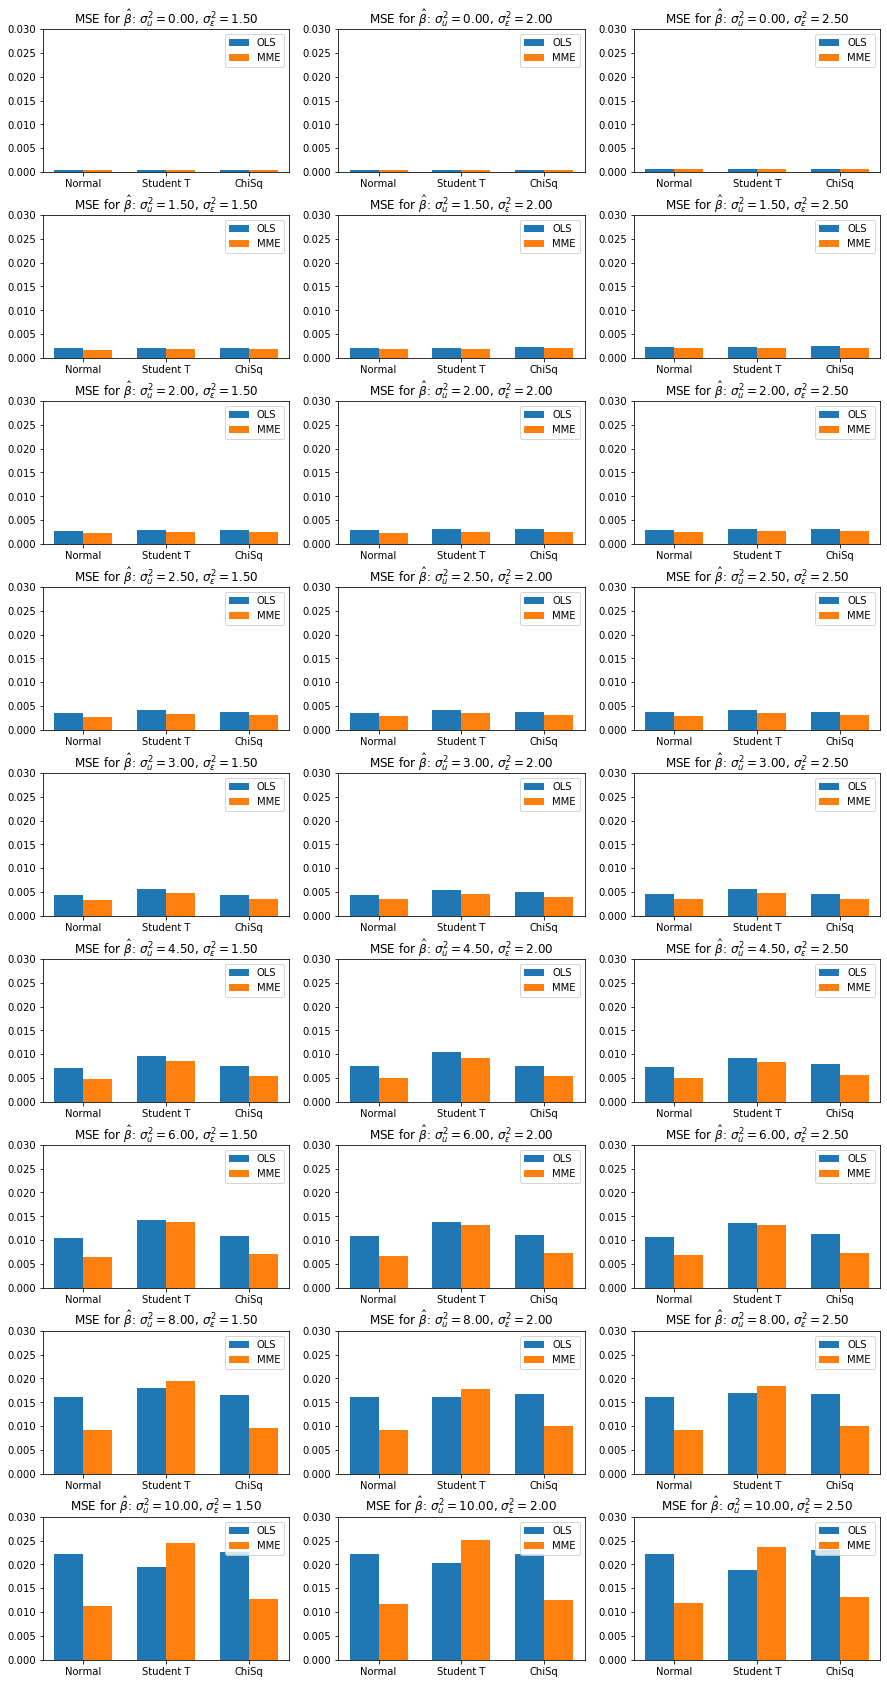

In [30]:
show_plot("MSE for $\\hat{\\beta}$", [beta_dict_normal, beta_dict_t, beta_dict_chi], ['Normal', 'Student T', 'ChiSq'], 'sqerr_ols', 'sqerr_ols_corr', 0, 0.03)

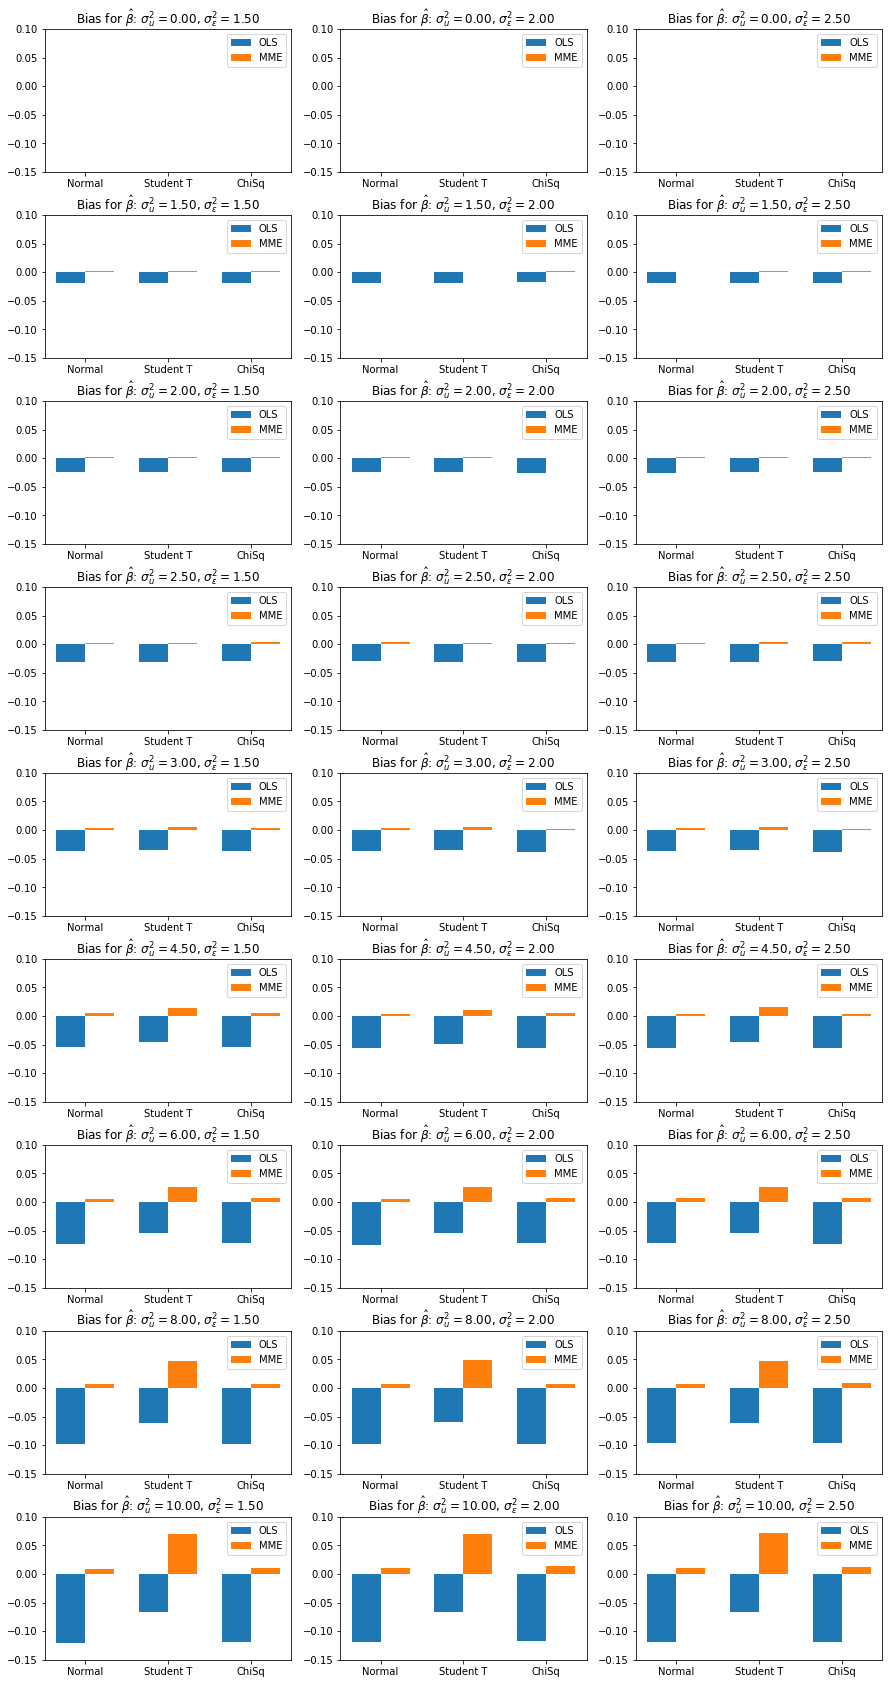

In [31]:
show_plot("Bias for $\\hat{\\beta}$", [beta_dict_normal, beta_dict_t, beta_dict_chi], ['Normal', 'Student T', 'ChiSq'], 'bias_ols', 'bias_ols_corr', -0.15, 0.1)

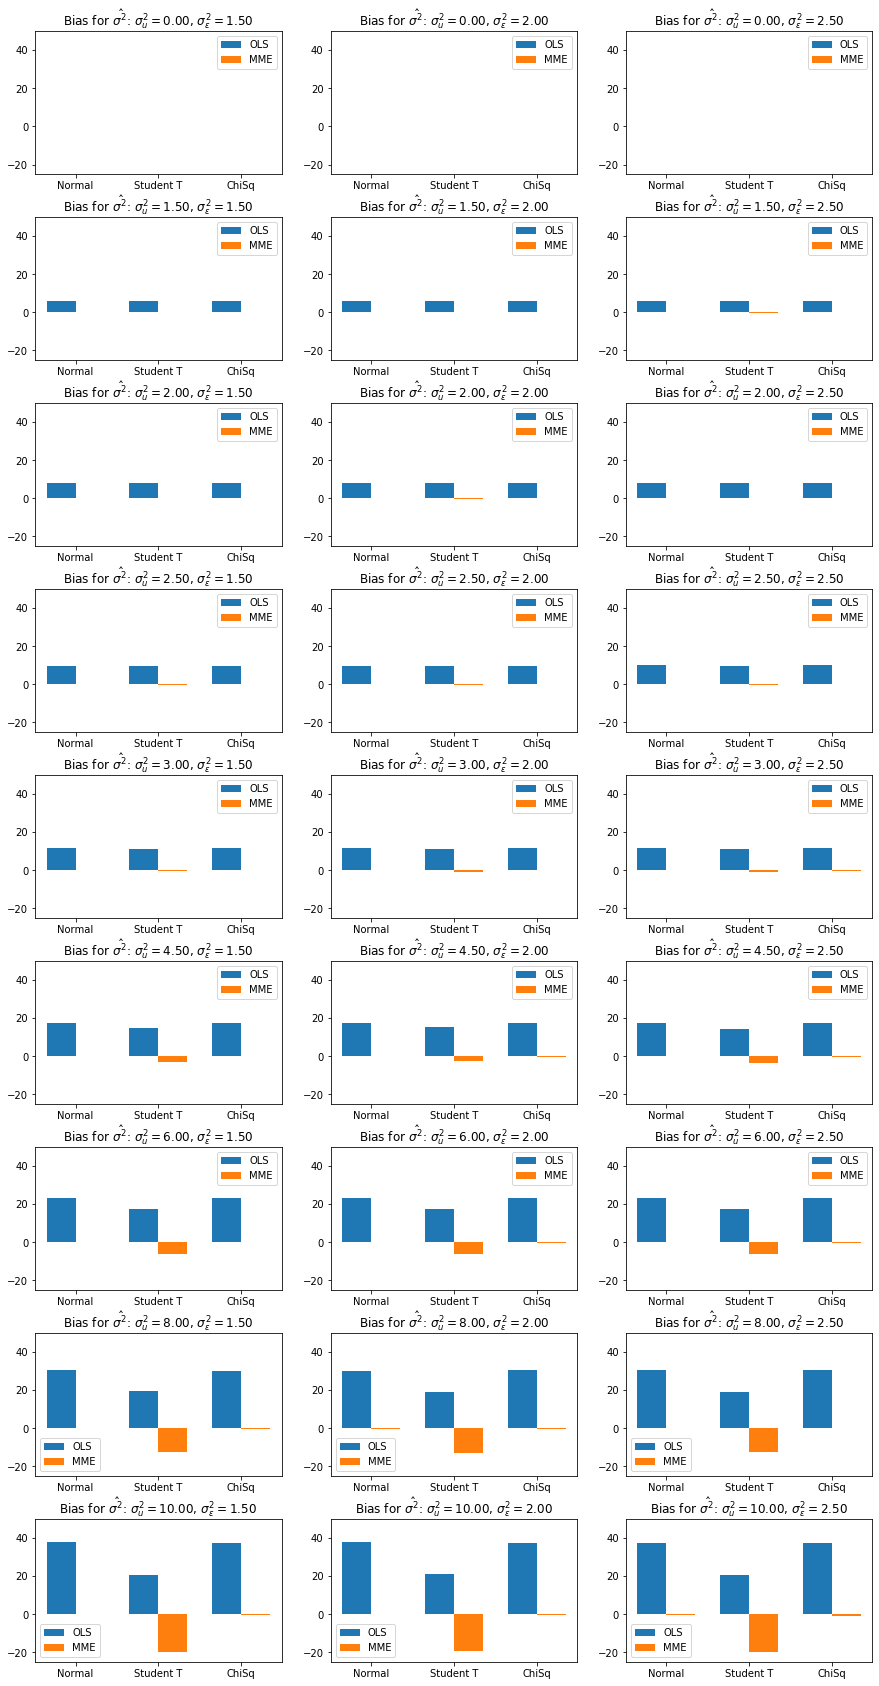

In [32]:
show_plot("Bias for $\\hat{\\sigma^2}$", [sigma_dict_normal, sigma_dict_t, sigma_dict_chi], ['Normal', 'Student T', 'ChiSq'], 'bias_ols', 'bias_ols_corr_v2', -25, 50.0)

Special property of assuming normal errors: Maximum likelihood estimation is exactly the same as OLS